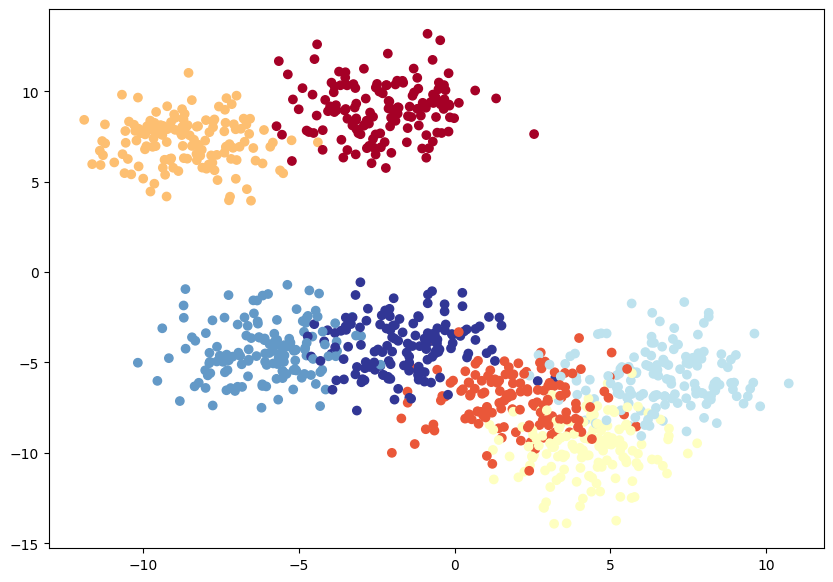

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


#Set the hyperparameters for data creating


NUM_CLASSES = 7
NUM_FEATURES = 3
RANDOM_SEED = 42


X_blob,y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers= NUM_CLASSES,
                           cluster_std= 1.5, #Adding a little bit of shakeup here std is standard deviation
                           random_state=RANDOM_SEED
                           )


X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)



X_blob_train,X_blob_test,y_blob_train,y_blob_test = train_test_split(X_blob,
                                                                      y_blob,
                                                                      test_size=0.2,
                                                                      random_state = RANDOM_SEED)


plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu);

In [ ]:
device = "cpu" if torch.cuda.is_available else "cpu"
device

'cpu'

In [ ]:
from torch import nn

In [ ]:
## Build a multi class classification model

class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units = 8):
    """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """

    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
        nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
    )
  def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=7, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(params = model_4.parameters(),
                            lr = 0.001)

In [ ]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-0.1903, -0.5939, -0.4410,  0.2099, -1.6119, -0.0949, -1.0158],
        [ 0.3324,  0.1552,  0.0289, -0.0732, -0.1121, -0.1133, -0.2061],
        [-0.2944, -0.6153, -0.4017,  0.2702, -1.7016, -0.0452, -1.0553],
        [ 0.1674, -0.1319, -0.0535, -0.3193, -0.1380, -0.0208, -0.3501],
        [ 0.1629, -0.1071, -0.0730, -0.0977, -0.0457, -0.1991, -0.0621]],
       grad_fn=<SliceBackward0>)

In [ ]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([7]), 7)

In [ ]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.0146, -0.1777, -0.1684, -0.1273, -0.0919, -0.1218, -0.0248],
        [-0.4585, -0.8474, -0.5607,  0.0251, -1.6383,  0.2177, -1.0554],
        [ 0.3290,  0.1593,  0.0414, -0.0819, -0.0858, -0.1035, -0.1956],
        [ 0.2112, -0.0727, -0.0418, -0.2801, -0.1212, -0.0456, -0.3172],
        [-0.2406, -0.4287, -0.2737,  0.2086, -1.3567, -0.0056, -0.8582]],
       grad_fn=<SliceBackward0>)
tensor([[0.1598, 0.1318, 0.1331, 0.1387, 0.1436, 0.1394, 0.1536],
        [0.1423, 0.0965, 0.1285, 0.2308, 0.0437, 0.2798, 0.0783],
        [0.1939, 0.1636, 0.1454, 0.1285, 0.1280, 0.1258, 0.1147],
        [0.1915, 0.1442, 0.1487, 0.1172, 0.1374, 0.1481, 0.1129],
        [0.1540, 0.1276, 0.1490, 0.2413, 0.0504, 0.1948, 0.0830]],
       grad_fn=<SliceBackward0>)


In [ ]:
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [ ]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1598, 0.1318, 0.1331, 0.1387, 0.1436, 0.1394, 0.1536],
       grad_fn=<SelectBackward0>)
tensor(0)


In [ ]:
## Calculate accuracy - out of 100 exampples,what percentage does our model get right

def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [ ]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.96574, Acc: 7.38% | Test Loss: 1.97828, Test Acc: 5.00%
Epoch: 10 | Loss: 1.90285, Acc: 10.88% | Test Loss: 1.91598, Test Acc: 10.50%
Epoch: 20 | Loss: 1.84396, Acc: 21.38% | Test Loss: 1.85617, Test Acc: 19.50%
Epoch: 30 | Loss: 1.78035, Acc: 28.75% | Test Loss: 1.78985, Test Acc: 26.00%
Epoch: 40 | Loss: 1.70849, Acc: 33.75% | Test Loss: 1.71259, Test Acc: 33.00%
Epoch: 50 | Loss: 1.62847, Acc: 41.88% | Test Loss: 1.62787, Test Acc: 43.00%
Epoch: 60 | Loss: 1.54333, Acc: 46.00% | Test Loss: 1.53853, Test Acc: 49.00%
Epoch: 70 | Loss: 1.45707, Acc: 48.00% | Test Loss: 1.44946, Test Acc: 48.50%
Epoch: 80 | Loss: 1.37399, Acc: 49.38% | Test Loss: 1.36474, Test Acc: 51.00%
Epoch: 90 | Loss: 1.29195, Acc: 54.87% | Test Loss: 1.28228, Test Acc: 58.50%


In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-1.6561, -1.4095, -1.1030, -0.2363, -0.8640,  0.5384,  0.6317],
        [ 0.1753, -2.6112,  0.0500, -0.8943, -2.6907, -0.8060, -2.6530],
        [ 0.1033,  0.1236, -0.0350, -0.2384,  0.1602, -0.1870, -0.3685],
        [-1.2454, -1.7174, -0.7554,  0.5329, -1.4963, -0.3581, -0.0085],
        [ 0.7785, -2.1753, -0.2452, -0.9850, -2.1492, -1.0827, -2.2803],
        [ 1.1106, -2.6303, -0.4335, -1.0887, -2.7194, -1.5006, -2.7992],
        [ 0.0996,  0.1208, -0.0392, -0.2390,  0.1612, -0.1852, -0.3727],
        [-0.5724, -0.6758, -0.4317,  0.0685, -0.4889, -0.1746,  0.1808],
        [ 1.2508, -2.3451, -0.5071, -1.2327, -2.1583, -1.3574, -2.3780],
        [-0.6584, -0.7478, -0.4916,  0.0862, -0.5323, -0.1466,  0.2360]])

In [ ]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([6, 0, 4, 3, 0, 0, 4, 6, 0, 6])
Labels: tensor([5, 2, 4, 3, 0, 0, 4, 6, 0, 6])
Test accuracy: 72.0%


In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


ValueError: x and y must be the same size

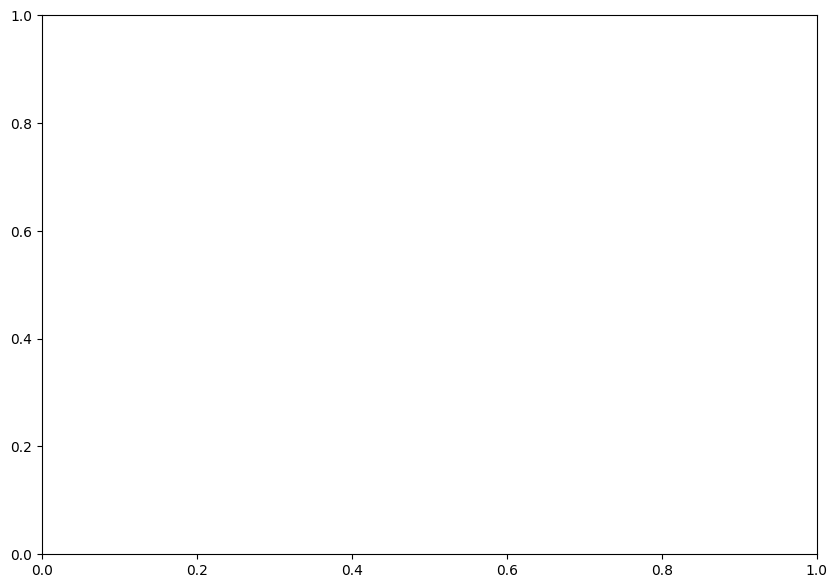

In [ ]:
from helper_functions import plot_predictions, plot_decision_boundary

# Example usage of plot_predictions
plot_predictions(X_blob_train, y_blob_train,  X_blob_test, y_blob_test)

In [ ]:
X_blob_train.size(),X_blob_test.size(),y_blob_train.size(),y_blob_test.size()

(torch.Size([800, 3]),
 torch.Size([200, 3]),
 torch.Size([800]),
 torch.Size([200]))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10201x2 and 3x8)

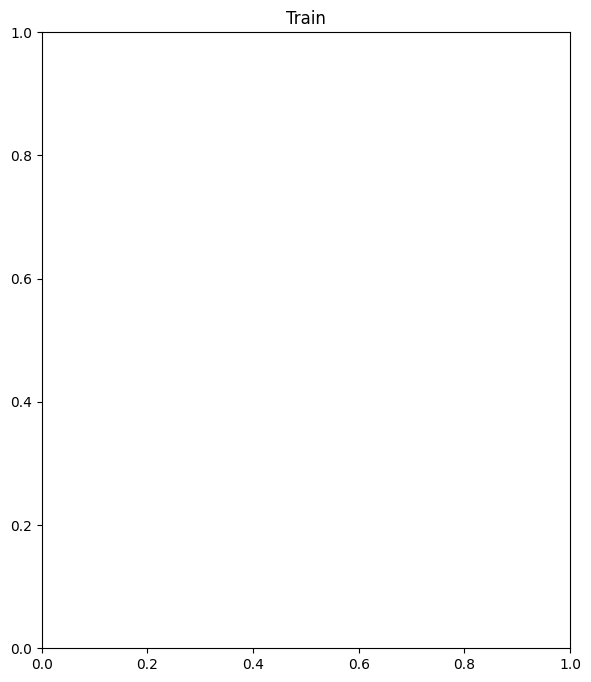

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

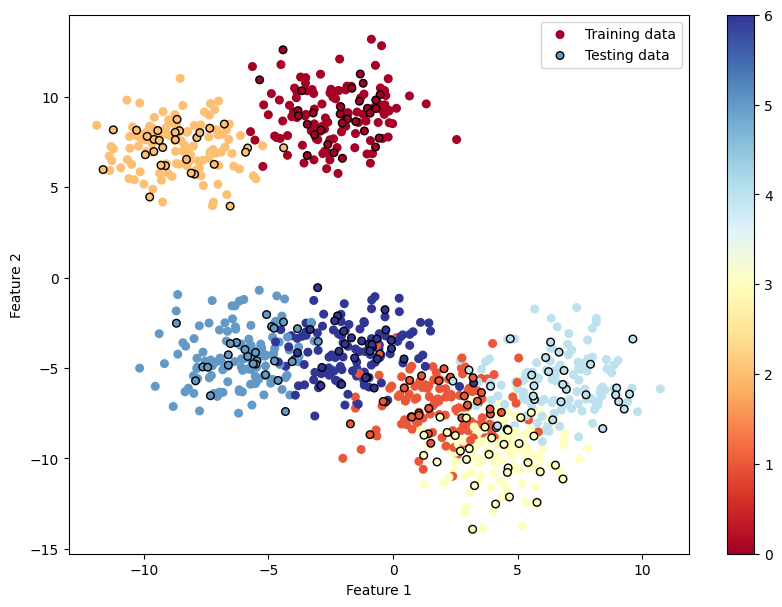

In [ ]:
def plot_data(X_train, y_train, X_test, y_test):
    plt.figure(figsize=(10, 7))
    # Plot training data in blue
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu, s=30, label="Training data")
    # Plot testing data in green
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.RdYlBu, s=30, edgecolors='k', label="Testing data")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.colorbar()
    plt.show()

# Call the modified plotting function
plot_data(X_blob_train.numpy(), y_blob_train.numpy(), X_blob_test.numpy(), y_blob_test.numpy())


In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

ValueError: The highest label in `target` should be smaller than `num_classes`.

In [ ]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()